In [2]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_5_2D_x1.json")

# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [3]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
from fpm_5_2D import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system



num sticking: 0
num sliding: 0
num open: 0
num transition: 32


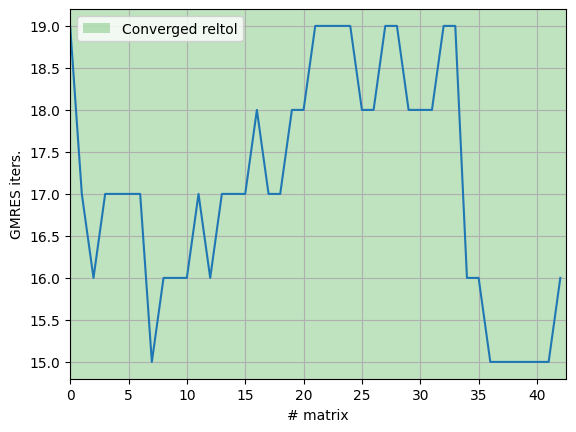

In [4]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [5]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

16

In [6]:
sticking, sliding, open_, transition = get_num_sticking_sliding_open_transition(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 11
sliding = 7
open = 14
transition = 0
total = 32


In [7]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


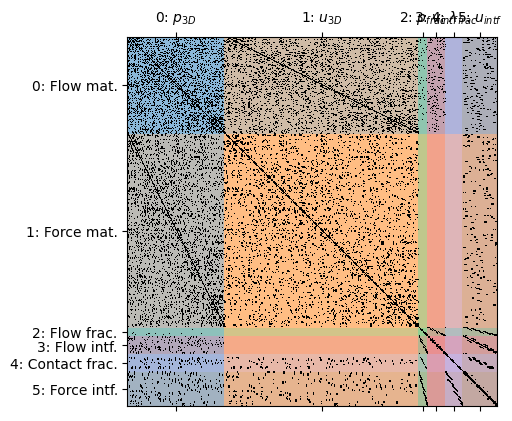

In [8]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
# solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))
J = perm_mat[:]
J.color_spy()

# Decoupling fractures from mechanics

Solve  took: 0.01
True residual decrease: 5.982394402367597e-11


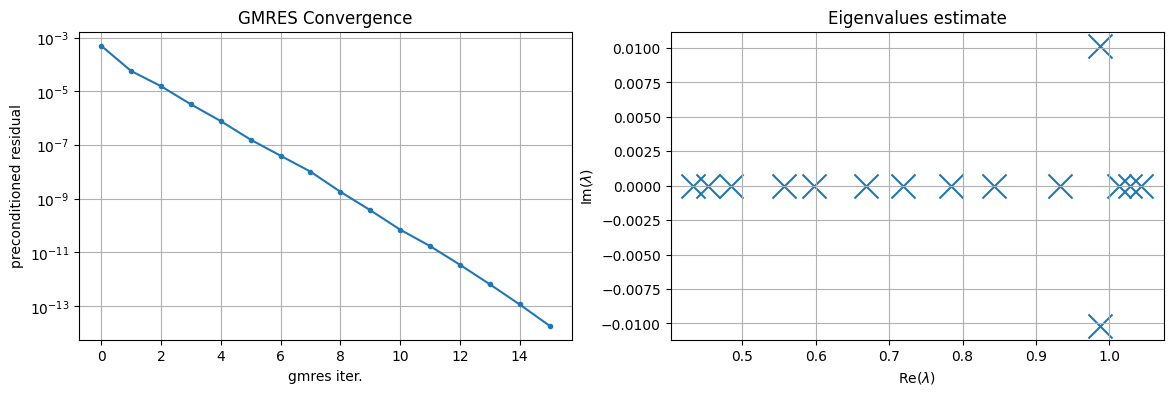

In [9]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(bmat[[4]].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

# Full (doesn't work if the open state is present)

Solve  took: 0.03
True residual decrease: 2.49517931183578e-11


Text(0.5, 1.0, 'Eigenvalues estimate')

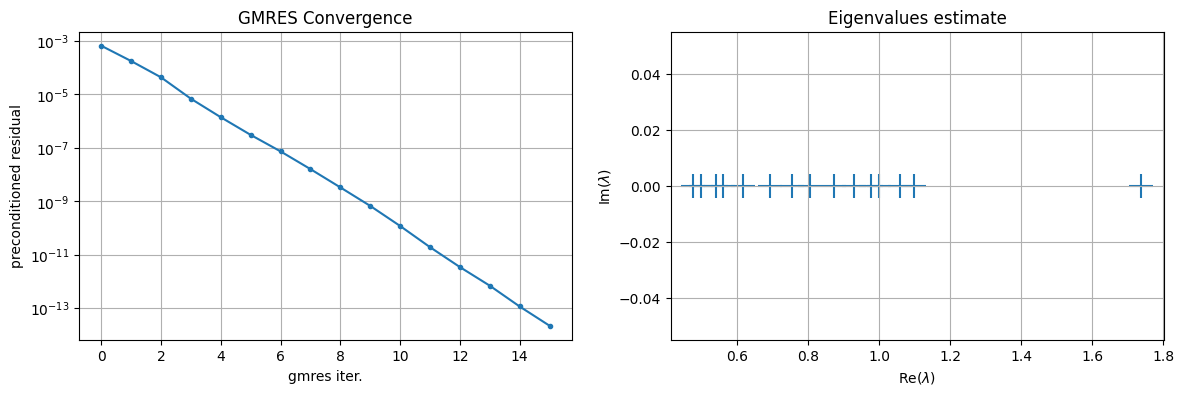

In [10]:
from block_matrix import SolveSchema, make_solver
from fixed_stress import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    # solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1]].mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
            )
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.subplot(1, 2, 1).set_title('GMRES Convergence')
plt.subplot(1, 2, 2).set_title('Eigenvalues estimate')

# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

# Fixed stress
For some reason, bad with sliding

Solve  took: 0.02
True residual decrease: 0.0033530056835169245


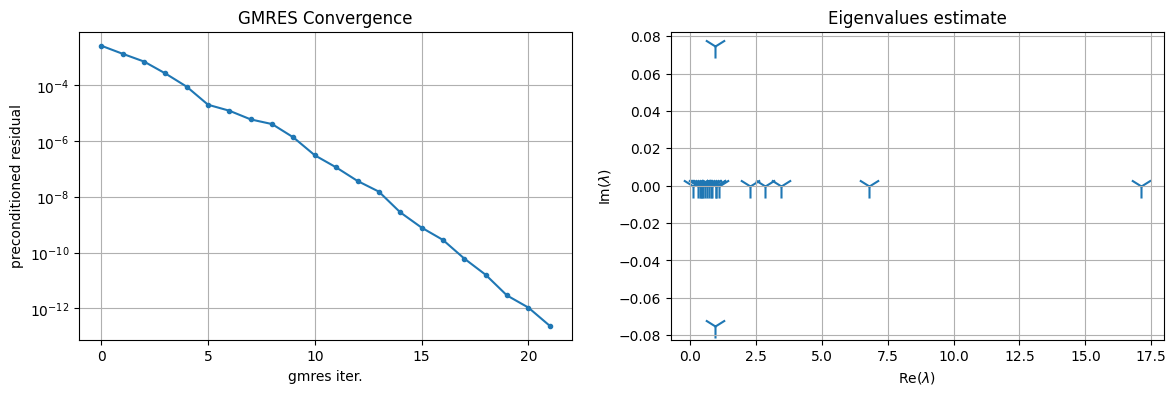

In [11]:
from block_matrix import SolveSchema, make_solver
from fixed_stress import (
    get_fixed_stress_stabilization,
    get_fixed_stress_stabilization_nd,
    make_local_stab_15,
)
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
    invertor_type="physical",
    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
    # invertor=lambda bmat: get_new_fixed_stress_stabilization_nd(model, bmat=bmat),
    invertor=lambda bmat: make_local_stab_15(bmat=bmat, base=2, nd=1),
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(bmat[[2]].mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.08
True residual decrease: 4.568904345013465e-09


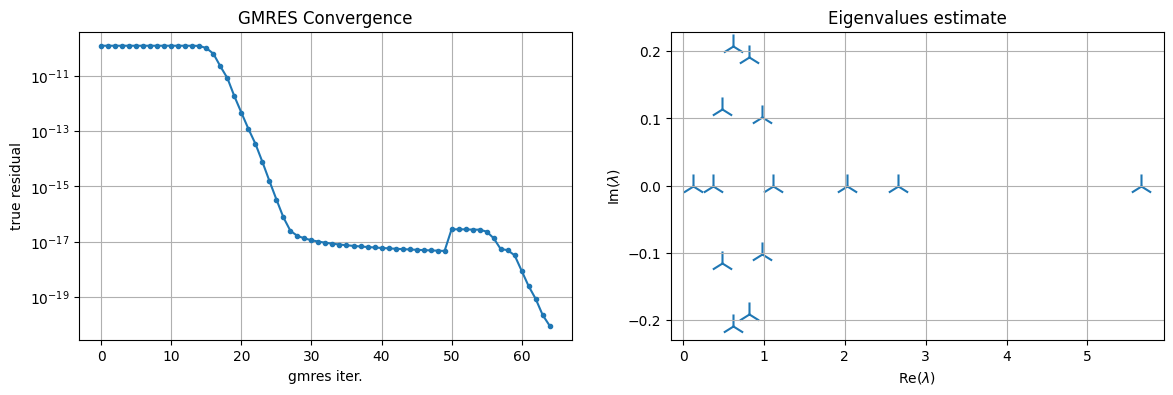

In [12]:
from block_matrix import SolveSchema, make_solver
from fixed_stress import get_fixed_stress_stabilization, make_fs, make_fs_experimental
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
    invertor_type="physical",
    invertor=lambda bmat: make_fs_experimental(model, bmat).mat,

    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd_new(model, bmat),
    # invertor=lambda bmat: make_S22_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), pc_side='right')

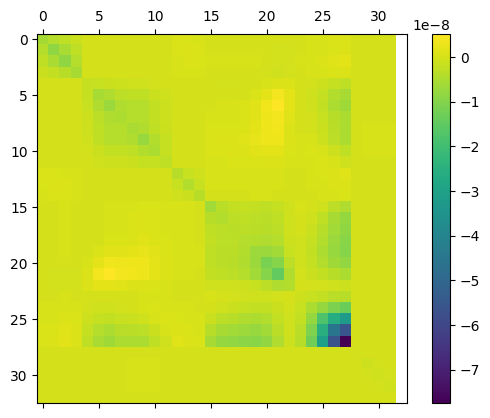